<a href="https://colab.research.google.com/github/snlrai/OCT/blob/main/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install pycocotools

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -U albumentations

IMPORT AND CONFIGURATION

In [3]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import os
import cv2
import numpy as np
from tqdm import tqdm
from pycocotools.coco import COCO
import json
from google.colab import drive
drive.mount('/content/drive')
PROJECT_FOLDER_IN_DRIVE='/content/drive/MyDrive/oct_major_project/'
UPLOADED_DATA_FOLDER='NORMAL 2.v1i.coco-segmentation'
DATA_DIR=os.path.join(PROJECT_FOLDER_IN_DRIVE,UPLOADED_DATA_FOLDER,'train/')
JSON_PATH=os.path.join(DATA_DIR,'_annotations.coco.json')
IMAGE_DIR=DATA_DIR
MASK_SAVE_DIR=os.path.join(DATA_DIR,'masks/')
os.makedirs(MASK_SAVE_DIR,exist_ok=True)
DEVICE= "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device : {DEVICE}")
LEARNING_RATE= 1e-4
BATCH_SIZE= 8
NUM_EPOCHS=75

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device : cuda


In [4]:
# IMPORTANT: Check category IDs and create mapping
print("Checking COCO categories...")
coco_check = COCO(JSON_PATH)

# Get all categories
categories = coco_check.loadCats(coco_check.getCatIds())
print(f"\nFound {len(categories)} categories:")
for cat in categories:
    print(f"  ID: {cat['id']}, Name: {cat['name']}")

# Create mapping from original category_id to consecutive indices starting from 0
# Background will be 0, and actual classes will be 1, 2, 3...
original_cat_ids = sorted([cat['id'] for cat in categories])
category_id_to_label = {cat_id: idx + 1 for idx, cat_id in enumerate(original_cat_ids)}
category_id_to_label[0] = 0  # Ensure background is 0

print(f"\nCategory mapping (original_id -> model_label):")
print(f"  Background: 0 -> 0")
for orig_id, new_label in sorted(category_id_to_label.items()):
    if orig_id != 0:
        cat_name = [cat['name'] for cat in categories if cat['id'] == orig_id][0]
        print(f"  {cat_name}: {orig_id} -> {new_label}")

NUM_CLASSES = len(categories) + 1  # +1 for background
print(f"\nTotal classes (including background): {NUM_CLASSES}")
print(f"Model should use out_channels={NUM_CLASSES}")


Checking COCO categories...
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!

Found 8 categories:
  ID: 0, Name: intra-retinal-layers-CgyO
  ID: 1, Name: GCL
  ID: 2, Name: INL
  ID: 3, Name: IPL
  ID: 4, Name: ONL
  ID: 5, Name: OPL
  ID: 6, Name: RNFL
  ID: 7, Name: RPE

Category mapping (original_id -> model_label):
  Background: 0 -> 0
  GCL: 1 -> 2
  INL: 2 -> 3
  IPL: 3 -> 4
  ONL: 4 -> 5
  OPL: 5 -> 6
  RNFL: 6 -> 7
  RPE: 7 -> 8

Total classes (including background): 9
Model should use out_channels=9


In [5]:
print("Loading coco json for segmentation")
coco=COCO(JSON_PATH)
img_ids= coco.getImgIds()
images=coco.loadImgs(img_ids)
print(f"Found {len(images)} images. startring mask generation")
for img_info in tqdm(images,desc="Gnerating maks"):
  img_id=img_info['id']
  img_file_name=img_info['file_name']
  img_height=img_info['height']
  img_width=img_info['width']
  mask=np.zeros((img_height,img_width),dtype=np.uint8)
  ann_ids= coco.getAnnIds(imgIds=img_id)
  anns=coco.loadAnns(ann_ids)
  for ann in anns:
    category_id=ann['category_id']
    # Map original category_id to model label (0-indexed)
    mapped_label = category_id_to_label.get(category_id, category_id)
    for seg in ann['segmentation']:
      poly=np.array(seg,dtype=np.int32).reshape((-1,1,2))
      cv2.fillPoly(mask,[poly],color=int(mapped_label))
  base_name=img_file_name.split('.')[0]
  mask_file_name=f"{base_name}.png"
  save_path=os.path.join(MASK_SAVE_DIR,mask_file_name)
  cv2.imwrite(save_path,mask)
print(f"Mask generation complete! the images are saved in{MASK_SAVE_DIR}")

Loading coco json for segmentation
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Found 20 images. startring mask generation


Gnerating maks: 100%|██████████| 20/20 [00:00<00:00, 92.53it/s]

Mask generation complete! the images are saved in/content/drive/MyDrive/oct_major_project/NORMAL 2.v1i.coco-segmentation/train/masks/


GROUND TRUTH MASK GENERATION

In [6]:
print("Loading COCO JSON for segmentation...")
# This assumes JSON_PATH and MASK_SAVE_DIR have been defined.
coco = COCO(JSON_PATH)
img_ids = coco.getImgIds()
images = coco.loadImgs(img_ids)

print(f"Found {len(images)} images. Starting mask generation...")

for img_info in tqdm(images, desc="Generating Masks"):
    img_id = img_info['id']
    img_file_name = img_info['file_name']
    img_height = img_info['height']
    img_width = img_info['width']

    mask = np.zeros((img_height, img_width), dtype=np.uint8)
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    for ann in anns:
        category_id = ann['category_id']
        # Map original category_id to model label (0-indexed)
        mapped_label = category_id_to_label.get(category_id, category_id)
        for seg in ann['segmentation']:
            poly = np.array(seg, dtype=np.int32).reshape((-1, 1, 2))
            cv2.fillPoly(mask, [poly], color=int(mapped_label))

    base_name = img_file_name.split('.')[0]
    mask_file_name = f"{base_name}.png"
    save_path = os.path.join(MASK_SAVE_DIR, mask_file_name)
    cv2.imwrite(save_path, mask)

print(f"\nMask generation complete! The images are saved in: {MASK_SAVE_DIR}")

Loading COCO JSON for segmentation...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Found 20 images. Starting mask generation...


Generating Masks: 100%|██████████| 20/20 [00:00<00:00, 110.96it/s]


Mask generation complete! The images are saved in: /content/drive/MyDrive/oct_major_project/NORMAL 2.v1i.coco-segmentation/train/masks/


In [7]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=8, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = torch.nn.functional.interpolate(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        return self.final_conv(x)

print("U-Net model class defined.")

U-Net model class defined.


UNET MODEL DEFENITION

In [8]:

import albumentations as A
from albumentations.pytorch import ToTensorV2

class RetinaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_file = self.images[index]
        mask_file = img_file.split('.')[0] + '.png'

        img_path = os.path.join(self.image_dir, img_file)
        mask_path = os.path.join(self.mask_dir, mask_file)

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:

            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].long()


        return image, mask


train_transform = A.Compose(
    [
        A.Resize(height=512, width=512),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=[0.0], std=[1.0]),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Resize(height=512, width=512),
        A.Normalize(mean=[0.0], std=[1.0]),
        ToTensorV2(),
    ]
)

CUSTOM DATASET CLASS

In [9]:
def train_fn(loader, model, optimizer, loss_fn):
    loop = tqdm(loader, desc="Training")
    total_loss = 0.0

    model.train()

    for batch_idx, (data, targets) in enumerate(loop):
        data, targets = data.to(device=DEVICE), targets.to(device=DEVICE)

        predictions = model(data)
        loss = loss_fn(predictions, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"Average training loss for the epoch: {total_loss / len(loader)}")

print("Training function defined.")

Training function defined.


In [10]:
# Clear CUDA cache to fix corrupted GPU state from previous error
import gc
import torch

print("Clearing CUDA cache and resetting GPU state...")
torch.cuda.empty_cache()
gc.collect()

# Optional: Reset CUDA error state (if available)
if torch.cuda.is_available():
    try:
        # This helps clear any lingering CUDA errors
        torch.cuda.synchronize()
        print(f"✓ GPU available: {torch.cuda.get_device_name(0)}")
        print(f"✓ GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
        print(f"✓ Current memory allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    except Exception as e:
        print(f"⚠ Warning: {e}")
        print("You may need to restart the runtime: Runtime -> Restart runtime")

print("✓ Ready to initialize model")


Clearing CUDA cache and resetting GPU state...
✓ GPU available: Tesla T4
✓ GPU memory: 14.74 GB
✓ Current memory allocated: 0.00 MB
✓ Ready to initialize model


In [11]:
def check_metrics(loader, model, device="cuda"):
    """
    Calculates and prints Pixel Accuracy, Dice Score, and IoU Score for a given dataset.
    """
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    iou_score = 0


    model.eval()

    with torch.no_grad():
        for x, y in tqdm(loader, desc="Calculating Metrics"):
            x = x.to(device)
            y = y.to(device)

            preds = model(x)
            preds = torch.argmax(preds, dim=1)


            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)

            y_one_hot = torch.nn.functional.one_hot(y, num_classes=model.final_conv.out_channels).permute(0, 3, 1, 2)
            preds_one_hot = torch.nn.functional.one_hot(preds, num_classes=model.final_conv.out_channels).permute(0, 3, 1, 2)
            intersection = (preds_one_hot * y_one_hot).float().sum()


            union = preds_one_hot.float().sum() + y_one_hot.float().sum()


            dice_score += (2. * intersection) / (union + 1e-8) # 1e-8 to avoid division by zero


            iou_score += intersection / (union - intersection + 1e-8)


    pixel_acc = (num_correct/num_pixels)*100
    avg_dice = (dice_score/len(loader))
    avg_iou = (iou_score/len(loader))

    print(f"\nGot {num_correct}/{num_pixels} with pixel accuracy {pixel_acc:.2f}%")
    print(f"Average Dice Score: {avg_dice:.4f}")
    print(f"Average IoU Score: {avg_iou:.4f}")


    model.train()

    return pixel_acc, avg_dice, avg_iou

Initializing model with 9 output classes...
Model initialized successfully!
Full dataset size: 20
Training indices: 16
Validation indices: 4

Datasets and DataLoaders created successfully with augmentations for the training set.

--- Epoch 1/75 ---


Training: 100%|██████████| 2/2 [00:09<00:00,  4.93s/it, loss=1.85]


Average training loss for the epoch: 1.8806010484695435

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it]



Got 874501/1048576 with pixel accuracy 83.40%
Average Dice Score: 0.8340
Average IoU Score: 0.7152

--- Epoch 2/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.01s/it, loss=1.78]


Average training loss for the epoch: 1.7847191095352173

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]



Got 875846/1048576 with pixel accuracy 83.53%
Average Dice Score: 0.8353
Average IoU Score: 0.7171

--- Epoch 3/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.03s/it, loss=1.69]


Average training loss for the epoch: 1.7119175791740417

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]



Got 875793/1048576 with pixel accuracy 83.52%
Average Dice Score: 0.8352
Average IoU Score: 0.7171

--- Epoch 4/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.11s/it, loss=1.65]


Average training loss for the epoch: 1.6622995138168335

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]



Got 865023/1048576 with pixel accuracy 82.50%
Average Dice Score: 0.8250
Average IoU Score: 0.7021

--- Epoch 5/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.07s/it, loss=1.64]


Average training loss for the epoch: 1.625132977962494

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]



Got 779045/1048576 with pixel accuracy 74.30%
Average Dice Score: 0.7430
Average IoU Score: 0.5910

--- Epoch 6/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.10s/it, loss=1.56]


Average training loss for the epoch: 1.5626985430717468

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]



Got 739154/1048576 with pixel accuracy 70.49%
Average Dice Score: 0.7049
Average IoU Score: 0.5443

--- Epoch 7/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it, loss=1.5]


Average training loss for the epoch: 1.5061160326004028

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]



Got 740266/1048576 with pixel accuracy 70.60%
Average Dice Score: 0.7060
Average IoU Score: 0.5456

--- Epoch 8/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.16s/it, loss=1.43]


Average training loss for the epoch: 1.4440391063690186

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]



Got 739667/1048576 with pixel accuracy 70.54%
Average Dice Score: 0.7054
Average IoU Score: 0.5449

--- Epoch 9/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.22s/it, loss=1.38]


Average training loss for the epoch: 1.388655185699463

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]



Got 752562/1048576 with pixel accuracy 71.77%
Average Dice Score: 0.7177
Average IoU Score: 0.5597

--- Epoch 10/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.24s/it, loss=1.32]


Average training loss for the epoch: 1.3329108357429504

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]



Got 739731/1048576 with pixel accuracy 70.55%
Average Dice Score: 0.7055
Average IoU Score: 0.5450

--- Epoch 11/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.27s/it, loss=1.27]


Average training loss for the epoch: 1.283322811126709

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]



Got 713540/1048576 with pixel accuracy 68.05%
Average Dice Score: 0.6805
Average IoU Score: 0.5157

--- Epoch 12/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.26s/it, loss=1.23]


Average training loss for the epoch: 1.2415615916252136

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.64it/s]



Got 688410/1048576 with pixel accuracy 65.65%
Average Dice Score: 0.6565
Average IoU Score: 0.4887

--- Epoch 13/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.19s/it, loss=1.19]


Average training loss for the epoch: 1.2058131694793701

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]



Got 678854/1048576 with pixel accuracy 64.74%
Average Dice Score: 0.6474
Average IoU Score: 0.4786

--- Epoch 14/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.20s/it, loss=1.16]


Average training loss for the epoch: 1.1698073744773865

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]



Got 772911/1048576 with pixel accuracy 73.71%
Average Dice Score: 0.7371
Average IoU Score: 0.5837

--- Epoch 15/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.20s/it, loss=1.13]


Average training loss for the epoch: 1.1367548704147339

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]



Got 808069/1048576 with pixel accuracy 77.06%
Average Dice Score: 0.7706
Average IoU Score: 0.6269

--- Epoch 16/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.15s/it, loss=1.11]


Average training loss for the epoch: 1.1111170649528503

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]



Got 807082/1048576 with pixel accuracy 76.97%
Average Dice Score: 0.7697
Average IoU Score: 0.6256

--- Epoch 17/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it, loss=1.09]


Average training loss for the epoch: 1.086342215538025

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



Got 756327/1048576 with pixel accuracy 72.13%
Average Dice Score: 0.7213
Average IoU Score: 0.5641

--- Epoch 18/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.10s/it, loss=1.07]


Average training loss for the epoch: 1.0651107430458069

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]



Got 873095/1048576 with pixel accuracy 83.26%
Average Dice Score: 0.8326
Average IoU Score: 0.7133

--- Epoch 19/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.12s/it, loss=1.05]


Average training loss for the epoch: 1.0447953939437866

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]



Got 925149/1048576 with pixel accuracy 88.23%
Average Dice Score: 0.8823
Average IoU Score: 0.7894

--- Epoch 20/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.15s/it, loss=1.02]


Average training loss for the epoch: 1.028920590877533

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]



Got 919760/1048576 with pixel accuracy 87.72%
Average Dice Score: 0.8772
Average IoU Score: 0.7812

--- Epoch 21/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.09s/it, loss=1]


Average training loss for the epoch: 1.0103017687797546

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]



Got 940792/1048576 with pixel accuracy 89.72%
Average Dice Score: 0.8972
Average IoU Score: 0.8136

--- Epoch 22/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.10s/it, loss=0.993]


Average training loss for the epoch: 0.9963907599449158

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]



Got 945316/1048576 with pixel accuracy 90.15%
Average Dice Score: 0.9015
Average IoU Score: 0.8207

--- Epoch 23/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.15s/it, loss=0.962]


Average training loss for the epoch: 0.9795643985271454

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]



Got 943962/1048576 with pixel accuracy 90.02%
Average Dice Score: 0.9002
Average IoU Score: 0.8186

--- Epoch 24/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.12s/it, loss=0.96]


Average training loss for the epoch: 0.9675275385379791

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]



Got 966875/1048576 with pixel accuracy 92.21%
Average Dice Score: 0.9221
Average IoU Score: 0.8554

--- Epoch 25/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it, loss=0.945]


Average training loss for the epoch: 0.95498126745224

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]



Got 963684/1048576 with pixel accuracy 91.90%
Average Dice Score: 0.9190
Average IoU Score: 0.8502

--- Epoch 26/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.21s/it, loss=0.944]


Average training loss for the epoch: 0.9448898732662201

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]



Got 976705/1048576 with pixel accuracy 93.15%
Average Dice Score: 0.9315
Average IoU Score: 0.8717

--- Epoch 27/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it, loss=0.928]


Average training loss for the epoch: 0.933123379945755

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]



Got 971238/1048576 with pixel accuracy 92.62%
Average Dice Score: 0.9262
Average IoU Score: 0.8626

--- Epoch 28/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it, loss=0.918]


Average training loss for the epoch: 0.9238753914833069

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]



Got 976034/1048576 with pixel accuracy 93.08%
Average Dice Score: 0.9308
Average IoU Score: 0.8706

--- Epoch 29/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it, loss=0.907]


Average training loss for the epoch: 0.9141866266727448

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]



Got 974402/1048576 with pixel accuracy 92.93%
Average Dice Score: 0.9293
Average IoU Score: 0.8679

--- Epoch 30/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it, loss=0.895]


Average training loss for the epoch: 0.9039328098297119

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]



Got 981036/1048576 with pixel accuracy 93.56%
Average Dice Score: 0.9356
Average IoU Score: 0.8790

--- Epoch 31/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.20s/it, loss=0.886]


Average training loss for the epoch: 0.895548403263092

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]



Got 980450/1048576 with pixel accuracy 93.50%
Average Dice Score: 0.9350
Average IoU Score: 0.8780

--- Epoch 32/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it, loss=0.882]


Average training loss for the epoch: 0.8822456002235413

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]



Got 980637/1048576 with pixel accuracy 93.52%
Average Dice Score: 0.9352
Average IoU Score: 0.8783

--- Epoch 33/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.16s/it, loss=0.879]


Average training loss for the epoch: 0.8734334111213684

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]



Got 981029/1048576 with pixel accuracy 93.56%
Average Dice Score: 0.9356
Average IoU Score: 0.8790

--- Epoch 34/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.20s/it, loss=0.855]


Average training loss for the epoch: 0.8658443093299866

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]



Got 980684/1048576 with pixel accuracy 93.53%
Average Dice Score: 0.9353
Average IoU Score: 0.8784

--- Epoch 35/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it, loss=0.862]


Average training loss for the epoch: 0.8601616621017456

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]



Got 980559/1048576 with pixel accuracy 93.51%
Average Dice Score: 0.9351
Average IoU Score: 0.8782

--- Epoch 36/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it, loss=0.843]


Average training loss for the epoch: 0.849505603313446

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]



Got 986245/1048576 with pixel accuracy 94.06%
Average Dice Score: 0.9406
Average IoU Score: 0.8878

--- Epoch 37/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.16s/it, loss=0.845]


Average training loss for the epoch: 0.8400362133979797

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]



Got 984125/1048576 with pixel accuracy 93.85%
Average Dice Score: 0.9385
Average IoU Score: 0.8842

--- Epoch 38/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it, loss=0.832]


Average training loss for the epoch: 0.8300718367099762

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]



Got 983133/1048576 with pixel accuracy 93.76%
Average Dice Score: 0.9376
Average IoU Score: 0.8825

--- Epoch 39/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it, loss=0.83]


Average training loss for the epoch: 0.8258220255374908

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]



Got 983307/1048576 with pixel accuracy 93.78%
Average Dice Score: 0.9378
Average IoU Score: 0.8828

--- Epoch 40/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it, loss=0.819]


Average training loss for the epoch: 0.8191957473754883

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]



Got 985942/1048576 with pixel accuracy 94.03%
Average Dice Score: 0.9403
Average IoU Score: 0.8873

--- Epoch 41/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it, loss=0.814]


Average training loss for the epoch: 0.8136532604694366

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]



Got 981694/1048576 with pixel accuracy 93.62%
Average Dice Score: 0.9362
Average IoU Score: 0.8801

--- Epoch 42/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.19s/it, loss=0.818]


Average training loss for the epoch: 0.805061399936676

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.33it/s]



Got 980673/1048576 with pixel accuracy 93.52%
Average Dice Score: 0.9352
Average IoU Score: 0.8784

--- Epoch 43/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it, loss=0.801]


Average training loss for the epoch: 0.7999957203865051

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.14it/s]



Got 984405/1048576 with pixel accuracy 93.88%
Average Dice Score: 0.9388
Average IoU Score: 0.8847

--- Epoch 44/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it, loss=0.781]


Average training loss for the epoch: 0.788529247045517

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]



Got 981036/1048576 with pixel accuracy 93.56%
Average Dice Score: 0.9356
Average IoU Score: 0.8790

--- Epoch 45/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.19s/it, loss=0.785]


Average training loss for the epoch: 0.7833806872367859

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]



Got 988976/1048576 with pixel accuracy 94.32%
Average Dice Score: 0.9432
Average IoU Score: 0.8924

--- Epoch 46/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it, loss=0.769]


Average training loss for the epoch: 0.7768145799636841

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]



Got 984546/1048576 with pixel accuracy 93.89%
Average Dice Score: 0.9389
Average IoU Score: 0.8849

--- Epoch 47/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.16s/it, loss=0.763]


Average training loss for the epoch: 0.7684445679187775

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]



Got 984079/1048576 with pixel accuracy 93.85%
Average Dice Score: 0.9385
Average IoU Score: 0.8841

--- Epoch 48/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.19s/it, loss=0.759]


Average training loss for the epoch: 0.7614381313323975

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]



Got 987462/1048576 with pixel accuracy 94.17%
Average Dice Score: 0.9417
Average IoU Score: 0.8899

--- Epoch 49/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it, loss=0.753]


Average training loss for the epoch: 0.7569814026355743

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]



Got 989331/1048576 with pixel accuracy 94.35%
Average Dice Score: 0.9435
Average IoU Score: 0.8930

--- Epoch 50/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it, loss=0.761]


Average training loss for the epoch: 0.7528604567050934

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]



Got 990364/1048576 with pixel accuracy 94.45%
Average Dice Score: 0.9445
Average IoU Score: 0.8948

--- Epoch 51/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it, loss=0.744]


Average training loss for the epoch: 0.7452762722969055

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]



Got 988247/1048576 with pixel accuracy 94.25%
Average Dice Score: 0.9425
Average IoU Score: 0.8912

--- Epoch 52/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it, loss=0.742]


Average training loss for the epoch: 0.7396275103092194

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]



Got 996314/1048576 with pixel accuracy 95.02%
Average Dice Score: 0.9502
Average IoU Score: 0.9051

--- Epoch 53/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.19s/it, loss=0.729]


Average training loss for the epoch: 0.7293046414852142

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]



Got 972718/1048576 with pixel accuracy 92.77%
Average Dice Score: 0.9277
Average IoU Score: 0.8651

--- Epoch 54/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it, loss=0.716]


Average training loss for the epoch: 0.7265826165676117

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.59it/s]



Got 988745/1048576 with pixel accuracy 94.29%
Average Dice Score: 0.9429
Average IoU Score: 0.8920

--- Epoch 55/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.15s/it, loss=0.714]


Average training loss for the epoch: 0.7175215482711792

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]



Got 996541/1048576 with pixel accuracy 95.04%
Average Dice Score: 0.9504
Average IoU Score: 0.9054

--- Epoch 56/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.12s/it, loss=0.707]


Average training loss for the epoch: 0.7135286033153534

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]



Got 988441/1048576 with pixel accuracy 94.27%
Average Dice Score: 0.9427
Average IoU Score: 0.8915

--- Epoch 57/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it, loss=0.707]


Average training loss for the epoch: 0.707312822341919

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]



Got 995644/1048576 with pixel accuracy 94.95%
Average Dice Score: 0.9495
Average IoU Score: 0.9039

--- Epoch 58/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it, loss=0.7]


Average training loss for the epoch: 0.7008922100067139

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]



Got 986551/1048576 with pixel accuracy 94.08%
Average Dice Score: 0.9408
Average IoU Score: 0.8883

--- Epoch 59/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.22s/it, loss=0.698]


Average training loss for the epoch: 0.6937190890312195

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]



Got 980021/1048576 with pixel accuracy 93.46%
Average Dice Score: 0.9346
Average IoU Score: 0.8773

--- Epoch 60/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it, loss=0.68]


Average training loss for the epoch: 0.6910252571105957

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]



Got 995330/1048576 with pixel accuracy 94.92%
Average Dice Score: 0.9492
Average IoU Score: 0.9033

--- Epoch 61/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it, loss=0.677]


Average training loss for the epoch: 0.6809307336807251

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]



Got 992713/1048576 with pixel accuracy 94.67%
Average Dice Score: 0.9467
Average IoU Score: 0.8988

--- Epoch 62/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.12s/it, loss=0.68]


Average training loss for the epoch: 0.6776739060878754

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]



Got 996573/1048576 with pixel accuracy 95.04%
Average Dice Score: 0.9504
Average IoU Score: 0.9055

--- Epoch 63/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it, loss=0.689]


Average training loss for the epoch: 0.6768469512462616

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]



Got 982880/1048576 with pixel accuracy 93.73%
Average Dice Score: 0.9373
Average IoU Score: 0.8821

--- Epoch 64/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.18s/it, loss=0.671]


Average training loss for the epoch: 0.6673215627670288

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



Got 983007/1048576 with pixel accuracy 93.75%
Average Dice Score: 0.9375
Average IoU Score: 0.8823

--- Epoch 65/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it, loss=0.678]


Average training loss for the epoch: 0.6678766310214996

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]



Got 976132/1048576 with pixel accuracy 93.09%
Average Dice Score: 0.9309
Average IoU Score: 0.8708

--- Epoch 66/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.15s/it, loss=0.661]


Average training loss for the epoch: 0.6616275608539581

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]



Got 944951/1048576 with pixel accuracy 90.12%
Average Dice Score: 0.9012
Average IoU Score: 0.8201

--- Epoch 67/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.18s/it, loss=0.649]


Average training loss for the epoch: 0.6597159802913666

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]



Got 920829/1048576 with pixel accuracy 87.82%
Average Dice Score: 0.8782
Average IoU Score: 0.7828

--- Epoch 68/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it, loss=0.669]


Average training loss for the epoch: 0.6707005202770233

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]



Got 968055/1048576 with pixel accuracy 92.32%
Average Dice Score: 0.9232
Average IoU Score: 0.8574

--- Epoch 69/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.16s/it, loss=0.664]


Average training loss for the epoch: 0.6562227010726929

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]



Got 980077/1048576 with pixel accuracy 93.47%
Average Dice Score: 0.9347
Average IoU Score: 0.8774

--- Epoch 70/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.20s/it, loss=0.655]


Average training loss for the epoch: 0.6610531508922577

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]



Got 976591/1048576 with pixel accuracy 93.13%
Average Dice Score: 0.9313
Average IoU Score: 0.8715

--- Epoch 71/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it, loss=0.661]


Average training loss for the epoch: 0.6556475758552551

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]



Got 991288/1048576 with pixel accuracy 94.54%
Average Dice Score: 0.9454
Average IoU Score: 0.8964

--- Epoch 72/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it, loss=0.64]


Average training loss for the epoch: 0.6423728168010712

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]



Got 975192/1048576 with pixel accuracy 93.00%
Average Dice Score: 0.9300
Average IoU Score: 0.8692

--- Epoch 73/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it, loss=0.633]


Average training loss for the epoch: 0.6382293701171875

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]



Got 985213/1048576 with pixel accuracy 93.96%
Average Dice Score: 0.9396
Average IoU Score: 0.8860

--- Epoch 74/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it, loss=0.629]


Average training loss for the epoch: 0.6300176978111267

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]



Got 969946/1048576 with pixel accuracy 92.50%
Average Dice Score: 0.9250
Average IoU Score: 0.8605

--- Epoch 75/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it, loss=0.622]


Average training loss for the epoch: 0.6274814605712891

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]



Got 995141/1048576 with pixel accuracy 94.90%
Average Dice Score: 0.9490
Average IoU Score: 0.9030

Training finished!


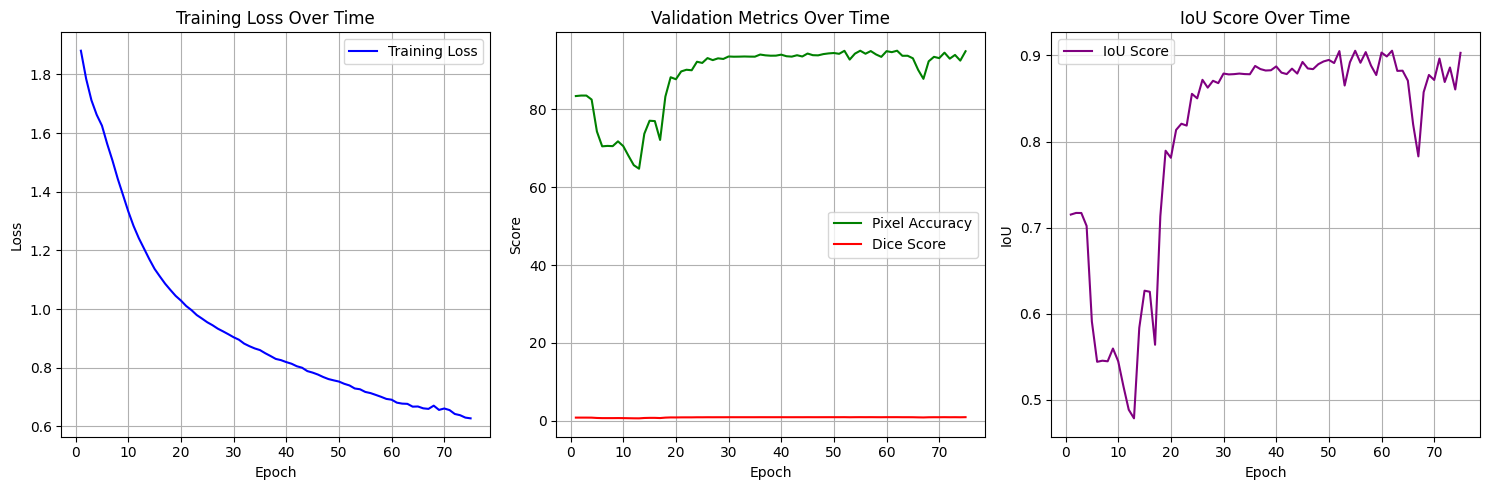


Final Metrics:
Final Training Loss: 0.6275
Final Pixel Accuracy: 94.90%
Final Dice Score: 0.9490
Final IoU Score: 0.9030

Model saved to /content/drive/MyDrive/oct_major_project/unet_retina_segmentation.pth


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Use NUM_CLASSES from the category mapping cell
print(f"Initializing model with {NUM_CLASSES} output classes...")
model = UNet(in_channels=1, out_channels=NUM_CLASSES).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(f"Model initialized successfully!")

from torch.utils.data import random_split, Subset

full_dataset_for_split = RetinaDataset(image_dir=IMAGE_DIR, mask_dir=MASK_SAVE_DIR)

train_size = int(0.8 * len(full_dataset_for_split))
val_size = len(full_dataset_for_split) - train_size
indices = list(range(len(full_dataset_for_split)))
train_indices, val_indices = random_split(indices, [train_size, val_size])

print(f"Full dataset size: {len(full_dataset_for_split)}")
print(f"Training indices: {len(train_indices)}")
print(f"Validation indices: {len(val_indices)}")

train_dataset_with_transform = RetinaDataset(
    image_dir=IMAGE_DIR,
    mask_dir=MASK_SAVE_DIR,
    transform=train_transform
)

val_dataset_with_transform = RetinaDataset(
    image_dir=IMAGE_DIR,
    mask_dir=MASK_SAVE_DIR,
    transform=val_transform
)

train_subset = Subset(train_dataset_with_transform, train_indices)
val_subset = Subset(val_dataset_with_transform, val_indices)

train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("\nDatasets and DataLoaders created successfully with augmentations for the training set.")

# Lists to store metrics
training_losses = []
validation_accuracies = []
validation_dice_scores = []
validation_iou_scores = []

# Training loop with metric tracking
for epoch in range(NUM_EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")

    # Training
    loop = tqdm(train_loader, desc="Training")
    total_loss = 0.0
    model.train()

    for batch_idx, (data, targets) in enumerate(loop):
        data, targets = data.to(device=DEVICE), targets.to(device=DEVICE)
        predictions = model(data)
        loss = loss_fn(predictions, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    training_losses.append(avg_loss)
    print(f"Average training loss for the epoch: {avg_loss}")

    # Validation
    print("\n--- VALIDATION METRICS ---")
    pixel_acc, dice, iou = check_metrics(val_loader, model, device=DEVICE)
    validation_accuracies.append(pixel_acc)
    validation_dice_scores.append(dice)
    validation_iou_scores.append(iou)

print("\nTraining finished!")

# Convert metrics to numpy arrays for plotting
training_losses = np.array(training_losses)
validation_accuracies = np.array([acc.cpu().numpy() if torch.is_tensor(acc) else acc for acc in validation_accuracies])
validation_dice_scores = np.array([dice.cpu().numpy() if torch.is_tensor(dice) else dice for dice in validation_dice_scores])
validation_iou_scores = np.array([iou.cpu().numpy() if torch.is_tensor(iou) else iou for iou in validation_iou_scores])

# Plotting the metrics
plt.figure(figsize=(15, 5))

# Plot 1: Training Loss
plt.subplot(1, 3, 1)
plt.plot(range(1, NUM_EPOCHS + 1), training_losses, 'b-', label='Training Loss')
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot 2: Validation Metrics (Accuracy and Dice Score)
plt.subplot(1, 3, 2)
plt.plot(range(1, NUM_EPOCHS + 1), validation_accuracies, 'g-', label='Pixel Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), validation_dice_scores, 'r-', label='Dice Score')
plt.title('Validation Metrics Over Time')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.grid(True)
plt.legend()

# Plot 3: IoU Score
plt.subplot(1, 3, 3)
plt.plot(range(1, NUM_EPOCHS + 1), validation_iou_scores, 'purple', label='IoU Score')
plt.title('IoU Score Over Time')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Print final metrics
print("\nFinal Metrics:")
print(f"Final Training Loss: {training_losses[-1]:.4f}")
print(f"Final Pixel Accuracy: {validation_accuracies[-1]:.2f}%")
print(f"Final Dice Score: {validation_dice_scores[-1]:.4f}")
print(f"Final IoU Score: {validation_iou_scores[-1]:.4f}")

# Save model
MODEL_SAVE_PATH = os.path.join(PROJECT_FOLDER_IN_DRIVE, "unet_retina_segmentation.pth")
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"\nModel saved to {MODEL_SAVE_PATH}")


TRAINING FUNTION

Loading model with 9 output classes...
Model loaded and ready for prediction.
Original image shape: (512, 512)
Resized to: (512, 512)


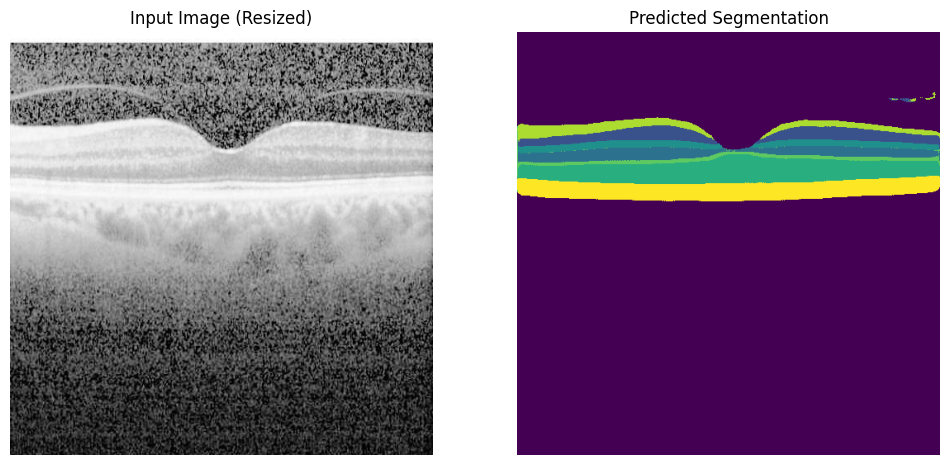

In [13]:

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

def predict_on_single_image(model, image_path, device):
    """
    Loads a single image, preprocesses it, runs it through the model,
    and visualizes the original image and the predicted mask.
    """

    model.eval()


    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return


    original_shape = image.shape
    image_resized = cv2.resize(image, (512, 512))

    image_normalized = image_resized.astype(np.float32) / 255.0
    image_processed = np.expand_dims(image_normalized, axis=0)

    input_tensor = torch.from_numpy(image_processed).unsqueeze(0).to(device)


    with torch.no_grad():
        output = model(input_tensor)
        predicted_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()


    print(f"Original image shape: {original_shape}")
    print(f"Resized to: {image_resized.shape}")

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(image_resized, cmap='gray')
    ax[0].set_title("Input Image (Resized)")
    ax[0].axis('off')

    ax[1].imshow(predicted_mask, cmap='viridis')
    ax[1].set_title("Predicted Segmentation")
    ax[1].axis('off')

    plt.show()





MODEL_SAVE_PATH = os.path.join(PROJECT_FOLDER_IN_DRIVE, "unet_retina_segmentation.pth")
print(f"Loading model with {NUM_CLASSES} output classes...")
model = UNet(in_channels=1, out_channels=NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
model.to(DEVICE)
print("Model loaded and ready for prediction.")



uploaded_image_path = '/content/drive/MyDrive/oct_major_project/NORMAL 2.v1i.coco-segmentation/train/NORMAL-266557-2_jpeg.rf.f9bef8a6442528dd660fe9b96ebadc6b.jpg'


predict_on_single_image(model, uploaded_image_path, DEVICE)